# Validation curves
In this notebook we will try to train an estimator over the training data, and every epoch, perform a evaluation on both the training data and the validation data. With this data we will plot the validation curves of the algorithm. 

We will also try to implement a mechanism to persist and restorethe model which achieved the best performance overall on the validation set and at the end use it to evaluate the model's generalization ability on the test set.

In [1]:
%matplotlib inline
# standard library
import itertools
import sys, os
import re
import glob
import shutil

# pandas
import pandas as pd
import dask.dataframe as dd
import dask.array as da
import dask


# numpy, matplotlib, seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# skealrn
from sklearn.metrics import precision_recall_fscore_support, classification_report, accuracy_score
from sklearn.utils import class_weight


# tesnsorflow
import tensorflow as tf

# local imports
sys.path.append(os.path.join(os.getcwd(), "../src"))

import tf_utils, tf_experiments

# this styling is purely my preference
# less chartjunk
sns.set_context('notebook', font_scale=1.5, rc={'line.linewidth': 2.5})
sns.set(style='ticks', palette='Set2')

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# define some constants
RANDOM_SEED = 42
BEST_CHECKPOINT_PATH = '/home/nikitautiu/models/best/best_dragnet2.ckpt'
MODEL_DIR = '/home/nikitautiu/models/dragnet_curves2/'

## Inputting the data
Using our in-memory caching dataset, we are going to load all the 3 datasets(train, validation, test) in memory.

In [3]:
# get the input functions and the initialization hooks to pass to the estimator
data_X, data_y, split_slices = tf_utils.get_numpy_datasets('../data/final/dragnet/')

Compute the balanced class weights using `sklearn` utils. It guarantees weight balance.

In [4]:
cls_weights = class_weight.compute_class_weight('balanced', [0, 1], data_y[split_slices[0]])
weights = data_y * cls_weights[1] + (~data_y * cls_weights[0])

Use numpy input to make input functions to ffeed to our estimator.

In [5]:
train_train_fn = tf.estimator.inputs.numpy_input_fn(x={'data': data_X[split_slices[0]], 'weights': weights[split_slices[0]]},
                                                    y=data_y[split_slices[0]], 
                                                    shuffle=True, num_epochs=10, batch_size=2000, queue_capacity=10000)
train_eval_fn = tf.estimator.inputs.numpy_input_fn(x={'data': data_X[split_slices[0]], 'weights': weights[split_slices[0]]},
                                                    y=data_y[split_slices[0]], 
                                                    shuffle=False, num_epochs=1, batch_size=2000, queue_capacity=10000)
validation_fn = tf.estimator.inputs.numpy_input_fn(x={'data': data_X[split_slices[1]], 'weights': weights[split_slices[1]]},
                                                        y=data_y[split_slices[1]], 
                                                        shuffle=False, num_epochs=1, batch_size=2000, queue_capacity=10000)
test_fn = tf.estimator.inputs.numpy_input_fn(x={'data': data_X[split_slices[2]], 'weights': weights[split_slices[2]]}, 
                                                   y=data_y[split_slices[2]], 
                                                   shuffle=False, num_epochs=1, batch_size=2000, queue_capacity=4000)

## Defining the model


In [ ]:
# # session workaround
sess_config = tf.ConfigProto()
sess_config.gpu_options.allow_growth = True

config = tf.estimator.RunConfig(
    model_dir=MODEL_DIR,
#     save_checkpoints_steps=10, 
    session_config=sess_config, 
    tf_random_seed=RANDOM_SEED
)

# we can infer the columns from the function, a bit costly, but better than hardcoding
tf_feat_cols = tf.contrib.learn.infer_real_valued_columns_from_input_fn(train_eval_fn)
estimator = tf.estimator.DNNClassifier(feature_columns=tf_feat_cols, hidden_units=(1000, 500, 200), 
                                        weight_column='weights', config=config)


INFO:tensorflow:Using config: {'_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f520ea61ac8>, '_log_step_count_steps': 100, '_num_ps_replicas': 0, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_master': '', '_model_dir': '/home/nikitautiu/models/dragnet_curves2/', '_task_type': 'worker', '_session_config': gpu_options {
  allow_growth: true
}
, '_is_chief': True, '_keep_checkpoint_max': 5, '_task_id': 0, '_num_worker_replicas': 1, '_tf_random_seed': 42, '_save_summary_steps': 100}


Now that we have the model, we can build the infrastructure  for testing out the training process and returning the losses and other metrics.

## Train loop
We are running the train/eval loop for 1500 epochs. The best models for validation are persisted

In [ ]:
metrics = tf_experiments.train_eval_loop(
    estimator=estimator, 
    train_input_fn=train_train_fn,
    num_epochs=1500, epoch_step=10,
    eval_input_fns={'train': train_eval_fn, 'validation': validation_fn},
    save_on_metric='f1-score', best_checkpoint_path=BEST_CHECKPOINT_PATH, save_set_name='validation'
)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/dragnet_curves2/model.ckpt-24949
INFO:tensorflow:Saving checkpoints for 24950 into /home/nikitautiu/models/dragnet_curves2/model.ckpt.
INFO:tensorflow:step = 24950, loss = 91.70186
INFO:tensorflow:global_step/sec: 10.3646
INFO:tensorflow:step = 25050, loss = 22.828194 (9.650 sec)
INFO:tensorflow:global_step/sec: 10.6611
INFO:tensorflow:step = 25150, loss = 20.649685 (9.380 sec)
INFO:tensorflow:global_step/sec: 10.792
INFO:tensorflow:step = 25250, loss = 23.482094 (9.265 sec)
INFO:tensorflow:global_step/sec: 10.754
INFO:tensorflow:step = 25350, loss = 52.149822 (9.299 sec)
INFO:tensorflow:global_step/sec: 10.6483
INFO:tensorflow:step = 25450, loss = 59.746445 (9.391 sec)
INFO:tensorflow:global_step/sec: 10.6589
INFO:tensorflow:step = 25550, loss = 32.453266 (9.382 sec)
INFO:tensorflow:global_step/sec: 10.7048
INFO:tensorflow:step = 25650, loss = 19.743036 (9.342 sec)
INFO:tensor

INFO:tensorflow:step = 31828, loss = 13.300343 (9.361 sec)
INFO:tensorflow:global_step/sec: 10.7026
INFO:tensorflow:step = 31928, loss = 28.206848 (9.343 sec)
INFO:tensorflow:global_step/sec: 10.782
INFO:tensorflow:step = 32028, loss = 9.513124 (9.275 sec)
INFO:tensorflow:global_step/sec: 10.7254
INFO:tensorflow:step = 32128, loss = 5.2648315 (9.324 sec)
INFO:tensorflow:global_step/sec: 10.7063
INFO:tensorflow:step = 32228, loss = 12.275843 (9.340 sec)
INFO:tensorflow:global_step/sec: 10.7354
INFO:tensorflow:step = 32328, loss = 76.43144 (9.315 sec)
INFO:tensorflow:global_step/sec: 10.6673
INFO:tensorflow:step = 32428, loss = 35.94575 (9.375 sec)
INFO:tensorflow:Saving checkpoints for 32505 into /home/nikitautiu/models/dragnet_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 10.122223.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/dragnet_curves2/model.ckpt-32505
train  ----  {'precision': 0.8986473045554009, 'support_other': 719179, 'epoch': 20,

INFO:tensorflow:step = 37984, loss = 107.9926 (9.441 sec)
INFO:tensorflow:global_step/sec: 10.7159
INFO:tensorflow:step = 38084, loss = 12.821323 (9.332 sec)
INFO:tensorflow:global_step/sec: 10.6965
INFO:tensorflow:step = 38184, loss = 41.48867 (9.349 sec)
INFO:tensorflow:global_step/sec: 10.6175
INFO:tensorflow:step = 38284, loss = 27.479607 (9.418 sec)
INFO:tensorflow:global_step/sec: 10.646
INFO:tensorflow:step = 38384, loss = 14.412562 (9.393 sec)
INFO:tensorflow:global_step/sec: 10.6404
INFO:tensorflow:step = 38484, loss = 5.5376687 (9.398 sec)
INFO:tensorflow:global_step/sec: 10.7004
INFO:tensorflow:step = 38584, loss = 171.7248 (9.345 sec)
INFO:tensorflow:global_step/sec: 10.6081
INFO:tensorflow:step = 38684, loss = 6.2308946 (9.427 sec)
INFO:tensorflow:global_step/sec: 10.6716
INFO:tensorflow:step = 38784, loss = 12.523874 (9.371 sec)
INFO:tensorflow:global_step/sec: 10.7437
INFO:tensorflow:step = 38884, loss = 203.1094 (9.308 sec)
INFO:tensorflow:global_step/sec: 10.648
INFO:t

INFO:tensorflow:step = 44040, loss = 13.155207 (9.340 sec)
INFO:tensorflow:global_step/sec: 10.6125
INFO:tensorflow:step = 44140, loss = 2.4469166 (9.423 sec)
INFO:tensorflow:global_step/sec: 10.6111
INFO:tensorflow:step = 44240, loss = 3.1220126 (9.424 sec)
INFO:tensorflow:global_step/sec: 10.6359
INFO:tensorflow:step = 44340, loss = 3.3293204 (9.401 sec)
INFO:tensorflow:global_step/sec: 10.7682
INFO:tensorflow:step = 44440, loss = 3.8610177 (9.287 sec)
INFO:tensorflow:global_step/sec: 10.6575
INFO:tensorflow:step = 44540, loss = 652.5847 (9.383 sec)
INFO:tensorflow:global_step/sec: 10.6523
INFO:tensorflow:step = 44640, loss = 154.35008 (9.387 sec)
INFO:tensorflow:global_step/sec: 10.6609
INFO:tensorflow:step = 44740, loss = 4.398532 (9.380 sec)
INFO:tensorflow:global_step/sec: 10.5861
INFO:tensorflow:step = 44840, loss = 1.9371891 (9.447 sec)
INFO:tensorflow:global_step/sec: 10.6205
INFO:tensorflow:step = 44940, loss = 2.631556 (9.416 sec)
INFO:tensorflow:global_step/sec: 10.8285
INF

INFO:tensorflow:step = 51218, loss = 7.825927 (9.386 sec)
INFO:tensorflow:global_step/sec: 10.6725
INFO:tensorflow:step = 51318, loss = 2.8997993 (9.370 sec)
INFO:tensorflow:Saving checkpoints for 51395 into /home/nikitautiu/models/dragnet_curves2/model.ckpt.
INFO:tensorflow:Loss for final step: 4.462754.

EVALUATION
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/dragnet_curves2/model.ckpt-51395
train  ----  {'precision': 0.9917228945283689, 'support_other': 719179, 'epoch': 70, 'accuracy': 0.9995962858296327, 'f1-score': 0.9958169325086061, 'recall': 0.9999449126866082, 'support': 36306}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/dragnet_curves2/model.ckpt-51395
validation  ----  {'precision': 0.9636192935101514, 'support_other': 167329, 'epoch': 70, 'accuracy': 0.9980179749171308, 'f1-score': 0.9792486583184258, 'recall': 0.9953933810158807, 'support': 8249}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters fro

INFO:tensorflow:global_step/sec: 10.5254
INFO:tensorflow:step = 57374, loss = 1.7148407 (9.501 sec)
INFO:tensorflow:global_step/sec: 10.7492
INFO:tensorflow:step = 57474, loss = 2.8333354 (9.303 sec)
INFO:tensorflow:global_step/sec: 10.557
INFO:tensorflow:step = 57574, loss = 3.0623558 (9.472 sec)
INFO:tensorflow:global_step/sec: 10.7205
INFO:tensorflow:step = 57674, loss = 44.468353 (9.328 sec)
INFO:tensorflow:global_step/sec: 10.6612
INFO:tensorflow:step = 57774, loss = 7.2915535 (9.380 sec)
INFO:tensorflow:global_step/sec: 10.6822
INFO:tensorflow:step = 57874, loss = 2.1210332 (9.361 sec)
INFO:tensorflow:global_step/sec: 10.689
INFO:tensorflow:step = 57974, loss = 3.725951 (9.356 sec)
INFO:tensorflow:global_step/sec: 10.5703
INFO:tensorflow:step = 58074, loss = 2.625276 (9.460 sec)
INFO:tensorflow:global_step/sec: 10.6903
INFO:tensorflow:step = 58174, loss = 2.3214426 (9.354 sec)
INFO:tensorflow:global_step/sec: 10.6152
INFO:tensorflow:step = 58274, loss = 372.48376 (9.420 sec)
INFO

INFO:tensorflow:global_step/sec: 10.7511
INFO:tensorflow:step = 63430, loss = 1.3894081 (9.302 sec)
INFO:tensorflow:global_step/sec: 10.6635
INFO:tensorflow:step = 63530, loss = 1.3369375 (9.378 sec)
INFO:tensorflow:global_step/sec: 10.6696
INFO:tensorflow:step = 63630, loss = 1.3724003 (9.372 sec)
INFO:tensorflow:global_step/sec: 10.7929
INFO:tensorflow:step = 63730, loss = 110.86881 (9.265 sec)
INFO:tensorflow:global_step/sec: 10.6172
INFO:tensorflow:step = 63830, loss = 2.499387 (9.419 sec)
INFO:tensorflow:global_step/sec: 10.6748
INFO:tensorflow:step = 63930, loss = 1.0699465 (9.368 sec)
INFO:tensorflow:global_step/sec: 10.7044
INFO:tensorflow:step = 64030, loss = 1.3797815 (9.342 sec)
INFO:tensorflow:global_step/sec: 10.6786
INFO:tensorflow:step = 64130, loss = 3.1262064 (9.365 sec)
INFO:tensorflow:global_step/sec: 10.5747
INFO:tensorflow:step = 64230, loss = 1.8075312 (9.457 sec)
INFO:tensorflow:global_step/sec: 10.7434
INFO:tensorflow:step = 64330, loss = 0.8130573 (9.308 sec)
I

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/dragnet_curves2/model.ckpt-70285
train  ----  {'precision': 0.8965849798461881, 'support_other': 719179, 'epoch': 120, 'accuracy': 0.994399624082543, 'f1-score': 0.9448693725975634, 'recall': 0.9986503608219027, 'support': 36306}
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/dragnet_curves2/model.ckpt-70285
validation  ----  {'precision': 0.7732212038174431, 'support_other': 167329, 'epoch': 120, 'accuracy': 0.9859549601886342, 'f1-score': 0.869052676295667, 'recall': 0.9919990301854771, 'support': 8249}

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/dragnet_curves2/model.ckpt-70285
INFO:tensorflow:Saving checkpoints for 70286 into /home/nikitautiu/models/dragnet_curves2/model.ckpt.
INFO:tensorflow:step = 70286, loss = 27.889845
INFO:tensorflow:global_step/sec: 10.4146
INFO:tensorflow:step = 70386, loss = 7.337803 (9.603 sec)
INFO:tensorf

INFO:tensorflow:step = 76564, loss = 2.8364606 (9.449 sec)
INFO:tensorflow:global_step/sec: 10.6795
INFO:tensorflow:step = 76664, loss = 0.82312775 (9.364 sec)
INFO:tensorflow:global_step/sec: 10.8195
INFO:tensorflow:step = 76764, loss = 0.52419454 (9.243 sec)
INFO:tensorflow:global_step/sec: 10.6282
INFO:tensorflow:step = 76864, loss = 0.8651291 (9.409 sec)
INFO:tensorflow:global_step/sec: 10.7427
INFO:tensorflow:step = 76964, loss = 0.4527385 (9.308 sec)
INFO:tensorflow:global_step/sec: 10.7071
INFO:tensorflow:step = 77064, loss = 23.272383 (9.340 sec)



## Results and vizualization

In [18]:
# retrieve the test metrics
test_metrics = tf_experiments.get_metrics(
    estimator=estimator, input_fn=test_fn, 
    checkpoint_path=BEST_CHECKPOINT_PATH,
)

INFO:tensorflow:Restoring parameters from /home/nikitautiu/models/best/best_dragnet2.ckpt


In [19]:
validation_stats = pd.DataFrame(metrics['validation'])
train_stats = pd.DataFrame(metrics['train'])
# set the epoch for the test stats from the best epoch of the validation
test_metrics['epoch'] =  validation_stats.loc[validation_stats['f1-score'].idxmax(), 'epoch']
test_stats = pd.DataFrame([test_metrics])  # build the df out of it

In [20]:
best_epoch = validation_stats.loc[validation_stats['f1-score'].idxmax(), 'epoch']
best_index = test_stats['epoch'] == best_epoch


print('BEST VALIDATION EPOCH - VALIDATION RESULTS')
print(validation_stats[validation_stats['epoch'] == best_epoch])
print('BEST VALIDATION EPOCH - TEST RESULTS')
print(test_stats[test_stats['epoch'] == best_epoch])

BEST VALIDATION EPOCH - VALIDATION RESULTS
    accuracy  epoch  f1-score  precision    recall  support  support_other
31  0.999812    320  0.997996   0.999757  0.996242     8249         167329
BEST VALIDATION EPOCH - TEST RESULTS
   accuracy  epoch  f1-score  precision    recall  support  support_other
0  0.999566    320  0.994935   0.999544  0.990367     6644         147721


### Accuracy

(<matplotlib.figure.Figure at 0x7f521cc1ca20>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f52d225a588>)

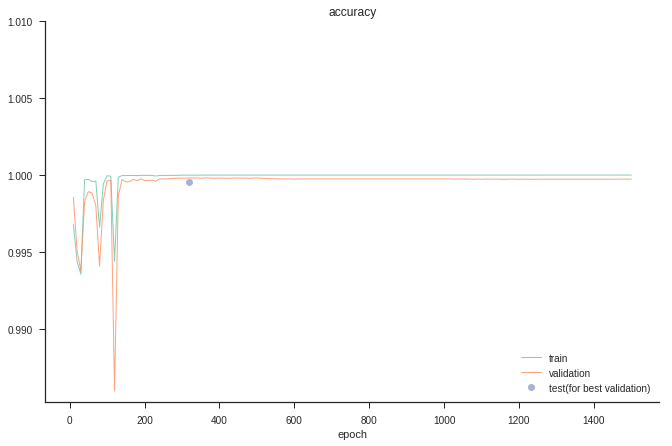

In [22]:
tf_experiments.plot_metric(train_stats, validation_stats, test_stats, 'accuracy', smoothing=1)

### Precision/Recall

(<matplotlib.figure.Figure at 0x7f52d1483b00>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f520fed5eb8>)

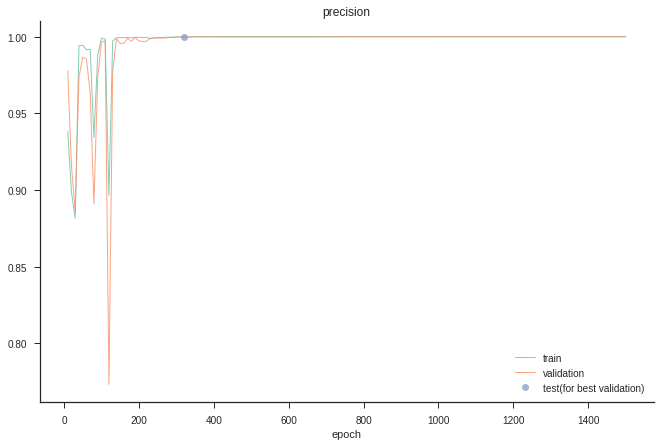

In [24]:
tf_experiments.plot_metric(train_stats, validation_stats, test_stats, 'precision', smoothing=1)

(<matplotlib.figure.Figure at 0x7f520ffce518>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f52d2661cc0>)

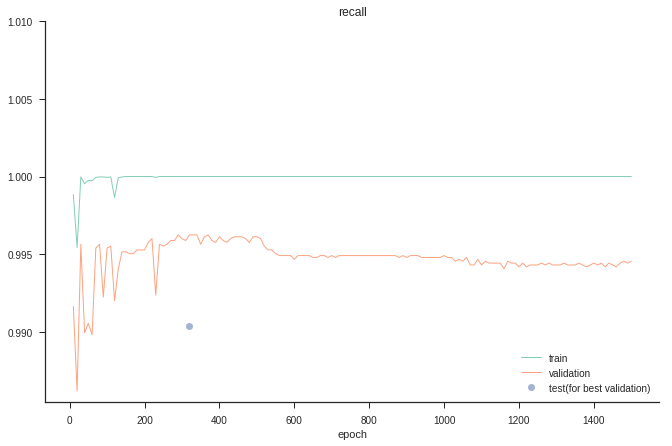

In [25]:
tf_experiments.plot_metric(train_stats, validation_stats, test_stats, 'recall', smoothing=1)

### F1-Score

(<matplotlib.figure.Figure at 0x7f520d55b390>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f520d58a0f0>)

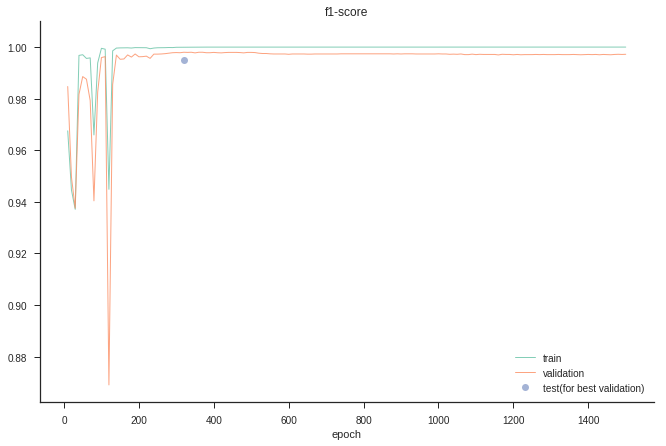

In [26]:
tf_experiments.plot_metric(train_stats, validation_stats, test_stats, 'f1-score', smoothing=1)

### Misc stats

In [27]:
# see the best values indxes for validation
validation_stats.idxmax()

accuracy          31
epoch            149
f1-score          31
precision         35
recall            28
support            0
support_other      0
dtype: int64

In [29]:
# also, here are the stats averaged over a rolling window of 50, resample in 50 steps
validation_stats.rolling(21, center=True).mean().dropna().iloc[100::20].drop('epoch', axis=1)

,accuracy,f1-score,precision,recall,support,support_other
110,0.999735,0.997169,0.999878,0.994476,8249.0,167329.0
130,0.999728,0.997094,0.999878,0.994325,8249.0,167329.0


In case we need them later, we will persist the results.

In [30]:
pd.concat([train_stats.assign(set='train'), 
           validation_stats.assign(set='validation'), 
           test_stats.assign(set='test')]).to_csv('../data/experimental-results/dragnet-validation-curves.csv')

## Conclusion
The validation curves look solid, an by looking at the indexes of the beest performanes on the validation set it looks like aroun the 1200-1400 mark, the performance seems to taper off and decrease. The performance is very good, but further confirmation should be done on different splits to have more statistically sound results.

The high similarity between the accuracy and precision could probably be traced to how skewed the dataset is, therefore small changes in performance on the training set would trainslate into changes for the other partitions as well due to the predominance of the negative class.